# Global-Conflict-Analysis

# Imports

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from transformers import AutoTokenizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

import torch 
from transformers import AutoModelForCausalLM, AutoModelForSequenceClassification, pipeline

# Functions

In [4]:
def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

def check_nulls_dupes(df):
  print(f"The Amount of Nulls: {df.isna().sum()}")
  print(f"The Amount of Dupes: {df.duplicated().sum()}")

def remove_stop_words(content):
  word_tokens = " ".join(word_tokenize(content))
  filtered_tokens = re.sub(r"[^a-zA-Z\s]", "", word_tokens).split(" ")
  filtered_word_tokens = [w.lower().strip() for w in filtered_tokens if w.lower() not in ENGLISH_STOP_WORDS]
  return " ".join(filtered_word_tokens).strip()

def lemmatize_words(content):
  
  lemma = WordNetLemmatizer()
  
  stop_free = " ".join([ word for word in content.lower().split() if word not in ENGLISH_STOP_WORDS])
  punc_free = "".join(re.sub(r"[^a-zA-Z\s]", "", stop_free))
  lemmatize_words = " ".join([lemma.lemmatize(word) for word in punc_free.split()])
  return lemmatize_words

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

def dist_plot(df):
  
  for col in df.columns:
    salary_skewness = df[col].skew()
    salary_kurtosis = df[col].kurtosis()

    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(f'Distribution of {col} with Skewness and Kurtosis')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
    plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

    plt.grid(True)
    plt.show()

# EDA Analysis

In [5]:
df = pd.read_csv("/Users/maukanmir/Downloads/data.csv")
df

,fromSocial,text,likesCount,commentsCount,viewsCount,input,authorMeta/name,creationDate
0,youtube,NaN,NaN,NaN,NaN,yemencivilwar,NaN,NaN
1,youtube,Russia-Ukraine Conflict: Putin Warns NATO Risk...,22.0,7.0,3069.0,russiaukraineconflict,CNN-News18,2024-09-13T16:23:39.000Z
2,youtube,LIVE: Russia Launches Waves of Drone Attacks o...,118.0,21.0,16358.0,russiaukraineconflict,Firstpost,2024-10-01T00:17:49.000Z
3,youtube,Russian Forces Take Over Ukraine's Avdiivka | ...,166.0,56.0,18054.0,russiaukraineconflict,CNBC-TV18,2024-02-19T15:37:34.000Z
4,youtube,Russia-Ukraine War: Ukraine's Surprise Attack ...,53.0,4.0,6096.0,russiaukraineconflict,DD India,2024-08-24T13:36:51.000Z
...,...,...,...,...,...,...,...,...
2541,youtube,Russia Ukraine War: उत्तर पश्चिम यूक्रेन पर बड...,2600.0,55.0,217668.0,russiaukraineconflict,News Nation,2024-08-20T13:35:00.000Z
2542,youtube,Russia Claims US Using Ukraine As Proxy. #russ...,323.0,11.0,5355.0,russiaukraineconflict,THE CHANAKYA DIALOGUES ENGLISH,2024-04-23T10:00:22.000Z
2543,youtube,Russia Ukraine Conflict live updates |Russian ...,352.0,1.0,51781.0,russiaukraineconflict,News18 Debate & Interview,2022-10-12T09:48:10.000Z
2544,youtube,When Ukraine Just Invaded Russia... 🇺🇦🇷🇺 #shor...,554.0,17.0,19076.0,russiaukraineconflict,The American Voice,2024-10-04T02:18:08.000Z


# Check For Class Imbalance

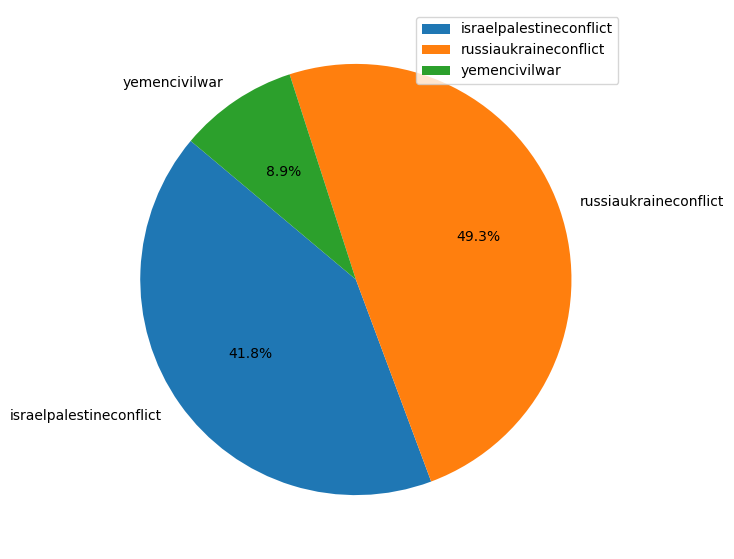

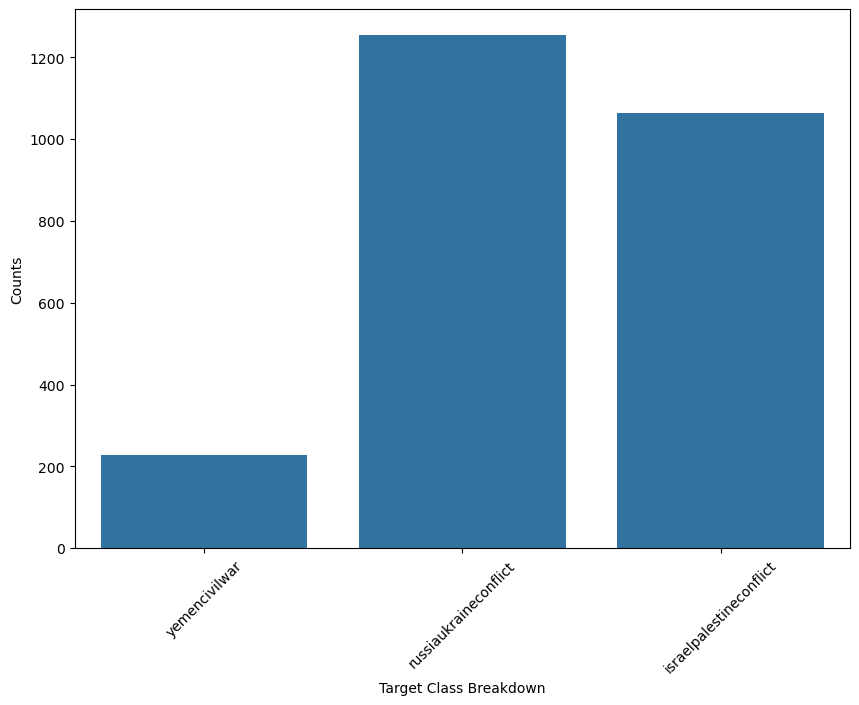

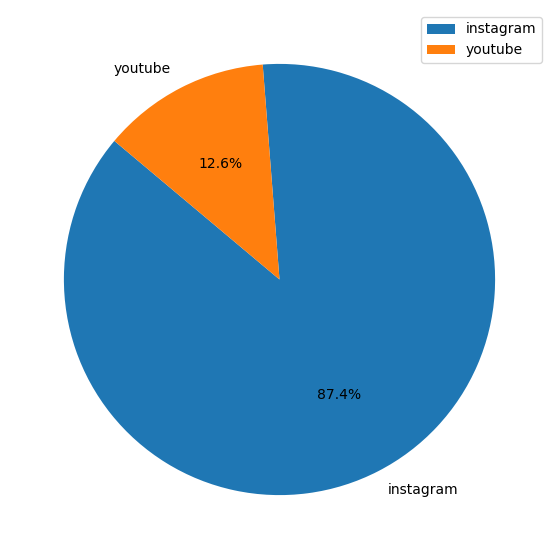

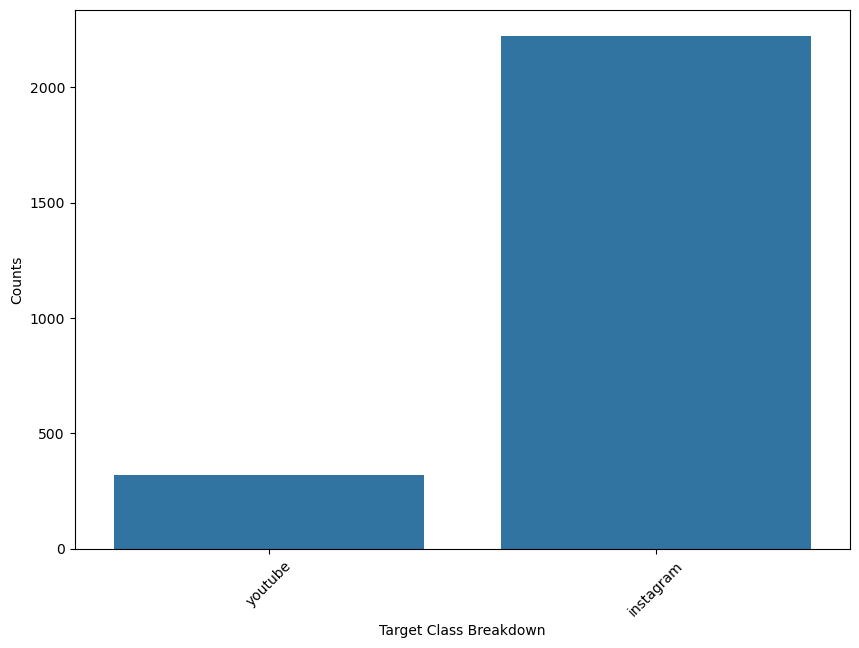

In [6]:
check_class_imbalance(df["input"])
check_class_imbalance(df["fromSocial"])

# Check For Nulls & Dupes

In [7]:
check_nulls_dupes(df)

The Amount of Nulls: fromSocial            0
text                  3
likesCount            1
commentsCount         1
viewsCount         2225
input                 0
authorMeta/name      63
creationDate          1
dtype: int64
The Amount of Dupes: 2


In [8]:
df.columns

Index(['fromSocial', 'text', 'likesCount', 'commentsCount', 'viewsCount',
       'input', 'authorMeta/name', 'creationDate'],
      dtype='object')

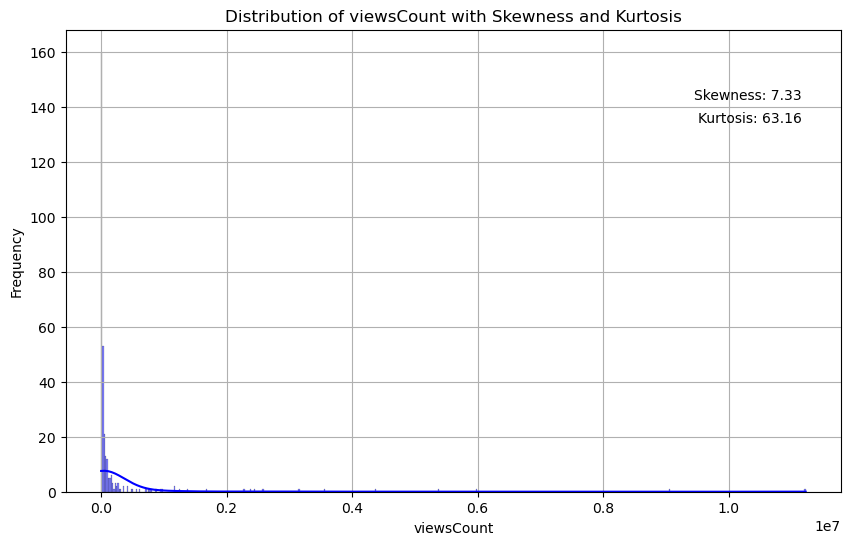

In [9]:
dist_plot(df[['viewsCount']])

# Fill in na values

In [10]:
df["viewsCount"] = df["viewsCount"].fillna(df["viewsCount"].median())

In [11]:
check_nulls_dupes(df)

The Amount of Nulls: fromSocial          0
text                3
likesCount          1
commentsCount       1
viewsCount          0
input               0
authorMeta/name    63
creationDate        1
dtype: int64
The Amount of Dupes: 2


In [12]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [13]:
df["len_text"] = df["text"].apply(lambda content: len(content))
df["num_words"] = df["text"].apply(lambda content: len(content.split()))

df["creationDate"] = pd.to_datetime(df["creationDate"])
df["year"] = df["creationDate"].dt.year
df["month"] = df["creationDate"].dt.month
df["day"] = df["creationDate"].dt.day
df["hour"] = df["creationDate"].dt.hour

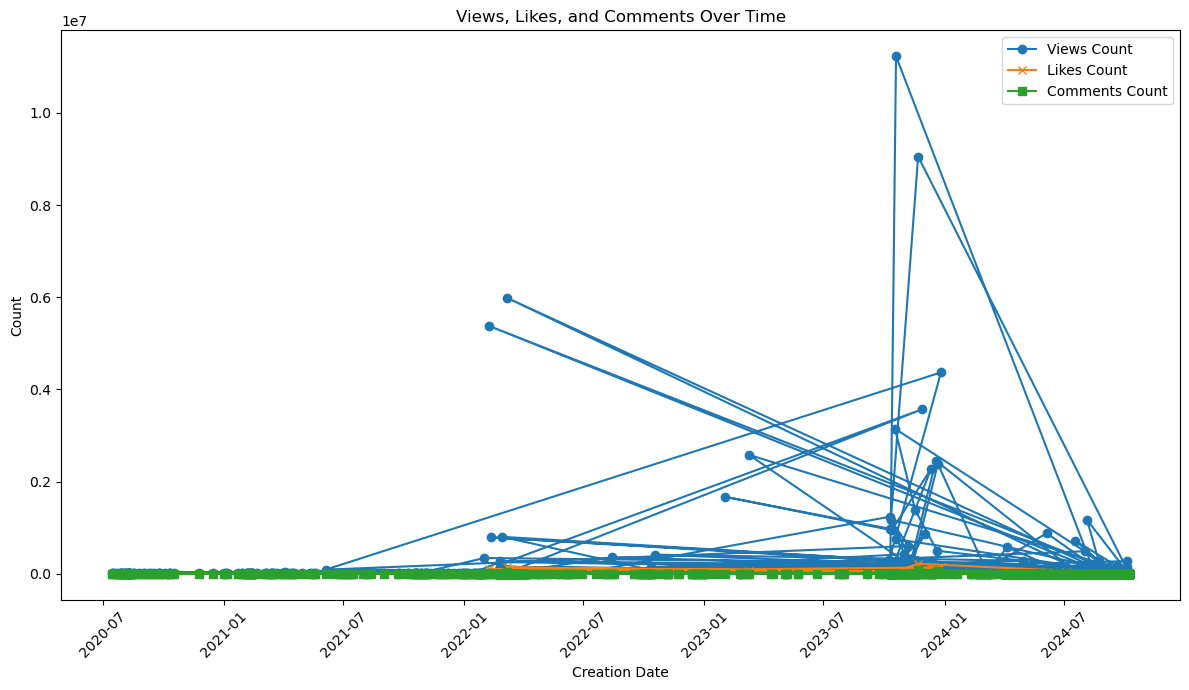

In [14]:
plt.figure(figsize=(12, 7))

plt.plot(df['creationDate'], df['viewsCount'], label='Views Count', marker='o')
plt.plot(df['creationDate'], df['likesCount'], label='Likes Count', marker='x')
plt.plot(df['creationDate'], df['commentsCount'], label='Comments Count', marker='s')

plt.xlabel('Creation Date')
plt.ylabel('Count')
plt.title('Views, Likes, and Comments Over Time')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

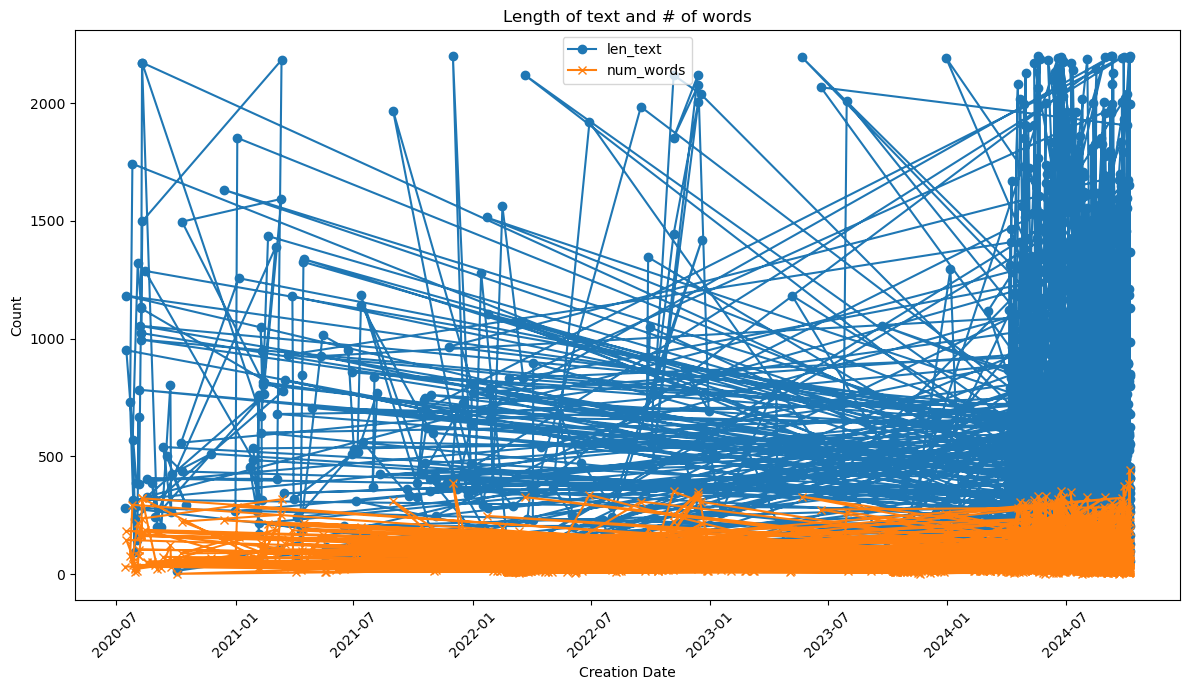

In [15]:
plt.figure(figsize=(12, 7))

plt.plot(df['creationDate'], df['len_text'], label='len_text', marker='o')
plt.plot(df['creationDate'], df['num_words'], label='num_words', marker='x')

plt.xlabel('Creation Date')
plt.ylabel('Count')
plt.title('Length of text and # of words')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Remove Stop Words

In [16]:
df['tokenize_text'] = df["text"].apply(remove_stop_words)

# Lemmatize Words

In [17]:
df["LDA_text"] = df["text"].apply(lemmatize_words)

# Check for empty Strings

In [18]:
df = df[df['LDA_text'].str.strip() != '']

In [19]:
count_vec = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")
dtm = count_vec.fit_transform(df["LDA_text"])

In [20]:
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5, learning_method='online', random_state=0)
lda.fit(dtm)

LatentDirichletAllocation(learning_method='online', max_iter=5, n_components=5,
                          random_state=0)

In [21]:
no_top_words = 10
display_topics(lda, count_vec.get_feature_names(), no_top_words)

topic_values = lda.transform(dtm)
df['topic'] = topic_values.argmax(axis=1)

Topic 0:
la di il yemen del le che una war ha
Topic 1:
ukraine russia israel conflict gaza israelpalestineconflict war russiaukraineconflict russian attack
Topic 2:
russiaukraineconflict russia news ukraine israel russiaukrainewar hamas trump palestine gaza
Topic 3:
palestine freepalestine israelpalestineconflict savepalestine palestinewillbefree israel genocide palestinian gaza justiceforpalestine
Topic 4:
yemen war president year country said india minister muslimlivesmatter iran


/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Topic Distribution

<AxesSubplot:xlabel='Topic Distribution', ylabel='Counts'>

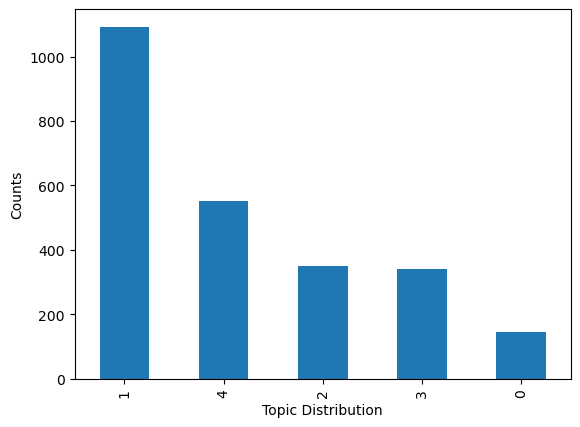

In [22]:
df["topic"].value_counts().plot.bar(xlabel="Topic Distribution", ylabel="Counts")

# BERT Sentiment Analysis

In [ ]:
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

texts = [
    "Absolutely fantastic service!",
    "Quite bad, won't recommend."
]

results = sentiment_pipeline(texts)

for text, result in zip(texts, results):
    print(f"Text: {text}")
    print(f"Sentiment: {result['label']}, Score: {result['score']:.4f}")
    print("-" * 50)


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Text: Absolutely fantastic service!
Sentiment: 5 stars, Score: 0.9596
--------------------------------------------------
Text: Quite bad, won't recommend.
Sentiment: 1 star, Score: 0.6120
--------------------------------------------------


In [ ]:
df["sentiment"] = df["tokenize_text"].apply(lambda x: sentiment_pipeline(x)[0]["label"])
df["score"] = df["tokenize_text"].apply(lambda x: sentiment_pipeline(x)[0]["score"])